## CycleGAN

#### 모듈 불러오기

In [1]:
import time
import numpy as np
from glob import glob   # ①
from tqdm import tqdm   # ②
from random import random
import matplotlib.pyplot as plt
from IPython.display import clear_output   # ③
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array   # ④

AUTOTUNE = tf.data.AUTOTUNE

## 하이퍼파라미터 설정

In [ ]:
BUFFER_SIZE = 1000  # ①
BATCH_SIZE = 1
IMG_SIZE = 128  # ②
LEARNING_RATE = 2e-4    # ③
EPOCHS = 40 

## 데이터 다운로드 및 압축 해제

## 데이터세트 생성

In [20]:
# 파일 다운로드
!gdown 1cAmCoIdEQLLPZYWJHaiPff1L6w-gUqAB
!unzip horse2zebra.zip  # ①

train_horse_path = './horse2zebra/trainA'
train_zebra_path = './horse2zebra/trainB'
test_horse_path = './horse2zebra/testA'
test_zebra_path = './horse2zebra/testB'

# 이미지 경로 리스트 생성
train_horse_paths = sorted(glob(train_horse_path + '/*.jpg'))   # ②
train_zebra_paths = sorted(glob(train_zebra_path + '/*.jpg'))
test_horse_paths = sorted(glob(test_horse_path + '/*.jpg'))
test_zebra_paths = sorted(glob(test_zebra_path + '/*.jpg'))

# 데이터세트 생성
train_horse_dataset = tf.data.Dataset.from_tensor_slices(train_horse_paths) # ③
train_zebra_dataset = tf.data.Dataset.from_tensor_slices(train_zebra_paths)
test_horse_dataset = tf.data.Dataset.from_tensor_slices(test_horse_paths)
test_zebra_dataset = tf.data.Dataset.from_tensor_slices(test_zebra_paths)

python(87561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Downloading...
From (original): https://drive.google.com/uc?id=1cAmCoIdEQLLPZYWJHaiPff1L6w-gUqAB
From (redirected): https://drive.google.com/uc?id=1cAmCoIdEQLLPZYWJHaiPff1L6w-gUqAB&confirm=t&uuid=bf5a3491-b404-4f06-b1ee-89a57c7b52ae
To: /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_Train/GAN/gan_other/horse2zebra.zip
100%|████████████████████████████████████████| 117M/117M [00:02<00:00, 44.7MB/s]
Archive:  horse2zebra.zip
replace horse2zebra/trainA/n02381460_6223.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

python(87607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


OSError: [Errno 5] Input/output error

## 이미지 전처리 함수 선언

In [5]:
def read_and_decode_image(image_path, channels=3):  # ①
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=channels)

def random_crop(image, size=IMG_SIZE):  # ②
    return tf.image.random_crop(image, size=[size, size, 3])

def normalize(image):   # ③
    return (tf.cast(image, tf.float32) / 127.5) - 1

def augment(image, resize_dim=224): # ④
    image = tf.image.resize(image, [resize_dim, resize_dim],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    return tf.image.random_flip_left_right(image)

def preprocess_image(image_path, augment_func=None):    # ⑤
    image = read_and_decode_image(image_path)
    if augment_func:
        image = augment_func(image)
    else:
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return normalize(image)

## 데이터세트에 이미지 전처리 적용

In [6]:
train_horses = train_horse_dataset.cache().map( # ①
    lambda x: preprocess_image(x, augment_func=augment),
    num_parallel_calls=AUTOTUNE # ②
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)    # ③

train_zebras = train_zebra_dataset.cache().map(
    lambda x: preprocess_image(x, augment_func=augment),
    num_parallel_calls=AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horse_dataset.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebra_dataset.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)


## 인스턴스 정규화 클래스 선언

In [7]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

## 생성자 함수 선언

In [8]:
def generator(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9):

    def residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = InstanceNormalization()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = InstanceNormalization()(h)

        return keras.layers.add([x, h])

    h = inputs = keras.Input(shape=input_shape)
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = InstanceNormalization()(h)
    h = tf.nn.relu(h)
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = InstanceNormalization()(h)
        h = tf.nn.relu(h)
    for _ in range(n_blocks):
        h = residual_block(h)
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = InstanceNormalization()(h)
        h = tf.nn.relu(h)
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)

## 판별자 함수 선언

In [9]:
def discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                      dim=64,
                      n_downsamplings=3):
    dim_ = dim
    h = inputs = keras.Input(shape=input_shape)
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = InstanceNormalization()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = InstanceNormalization()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)

## 판별자 및 생성자 선언, 옵티마이저 적용

In [11]:
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

generator_g_optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE, beta_1=0.5)

## 손실 함수 선언

In [12]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## 체크포인트 설정

In [14]:
checkpoint_path = "./checkpoints_cycleGAN/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## 학습 결과 시각화 함수 선언

In [15]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## 학습 함수 선언

In [16]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True) # ①
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True) # ②
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)    # ③
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)    # ④
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, # ⑤
                                            generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                            generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                                discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                                discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                                generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                                generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    discriminator_y.trainable_variables))

## 모델 학습

Horse -> Zebra


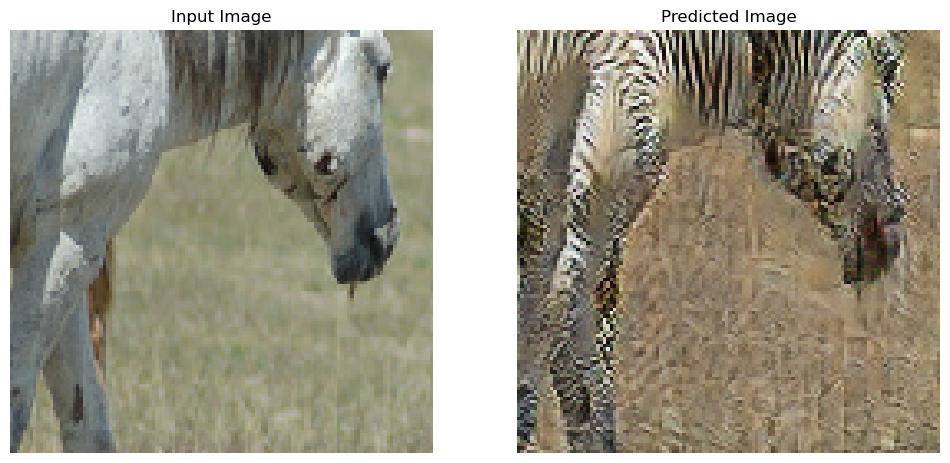

Zebra -> Horse


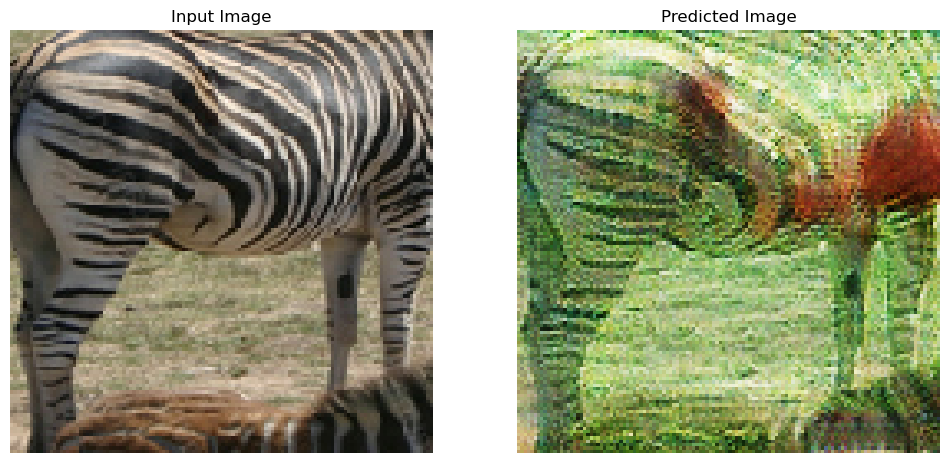

40번 째 에포크에 대한 체크포인트를 ./checkpoints_cycleGAN/train/ckpt-8에 저장합니다
40번 째 에포크 학습 소요 시간: 264.59363079071045초



In [17]:
for epoch in range(EPOCHS):
    start = time.time()
    for image_x, image_y in tqdm(tf.data.Dataset.zip((train_horses, train_zebras))):
        train_step(image_x, image_y)

    clear_output(wait=True)
    print("Horse -> Zebra")
    generate_images(generator_g, np.array([image_x[0]]))
    print("Zebra -> Horse")
    generate_images(generator_f, np.array([image_y[0]]))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('{}번 째 에포크에 대한 체크포인트를 {}에 저장합니다'.format(epoch+1,
                                                            ckpt_save_path))
    print ('{}번 째 에포크 학습 소요 시간: {}초\n'.format(epoch + 1,
                                                        time.time()-start))

## 학습 결과 출력

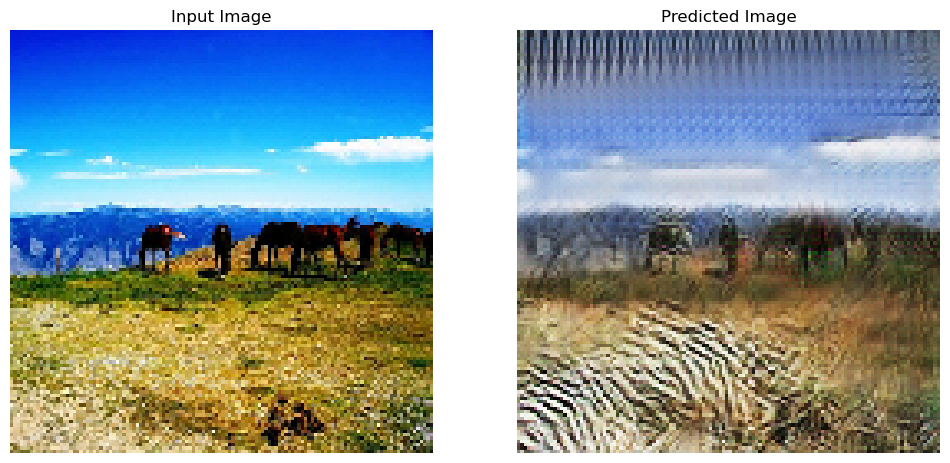

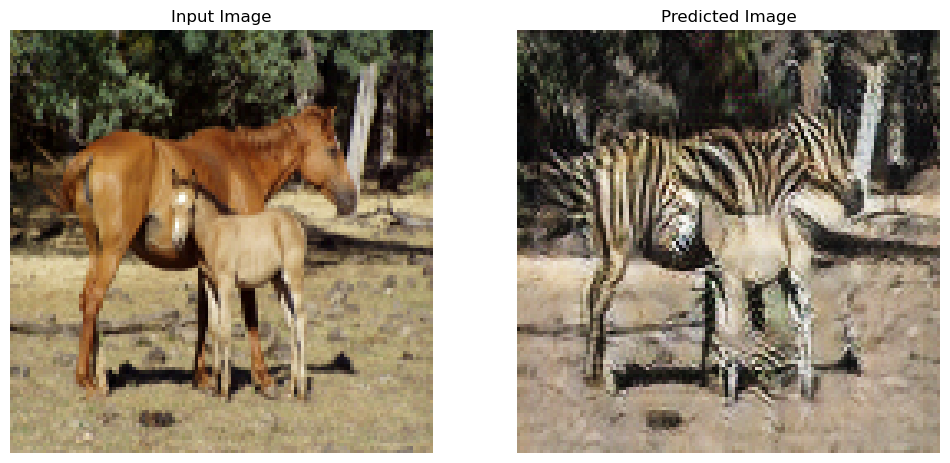

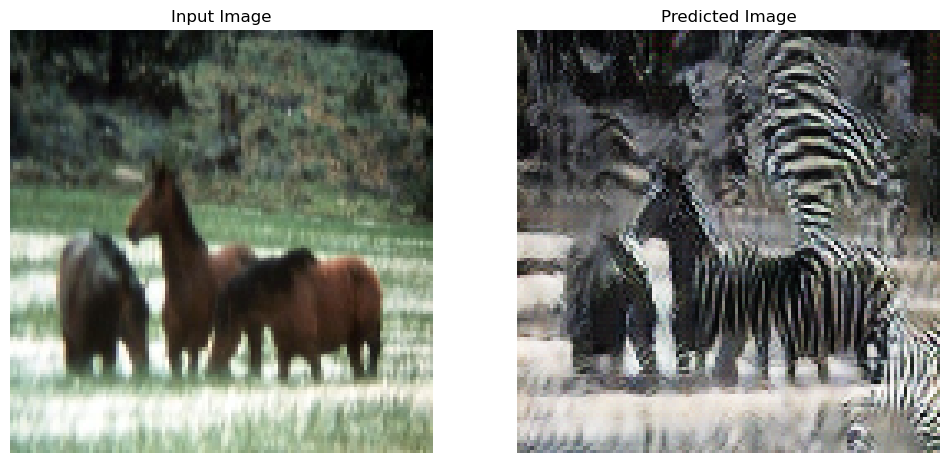

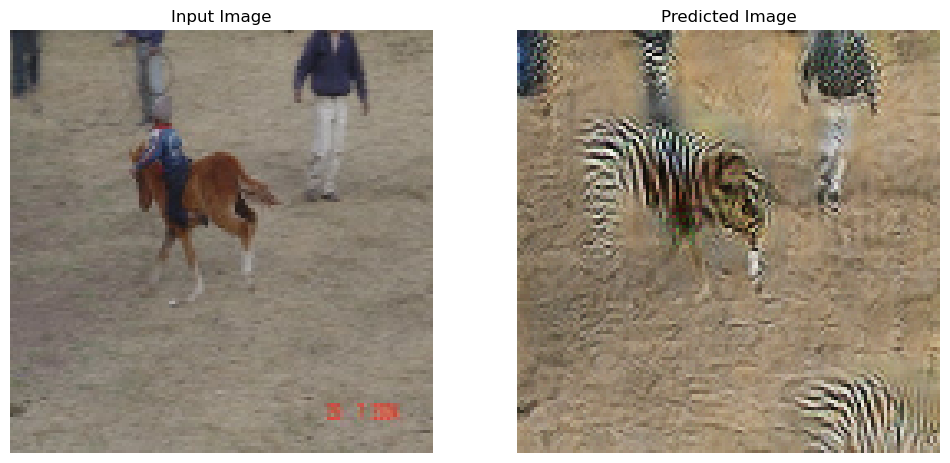

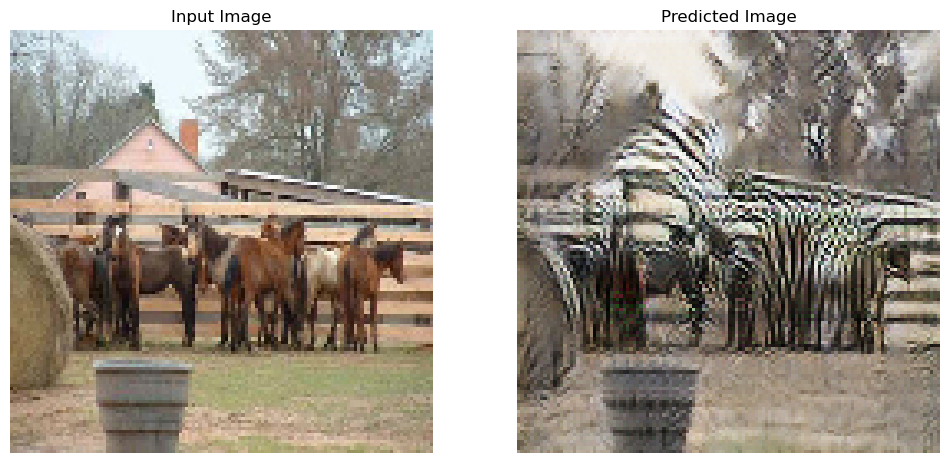

In [18]:
for img in test_horses.take(5):
    generate_images(generator_g, img)

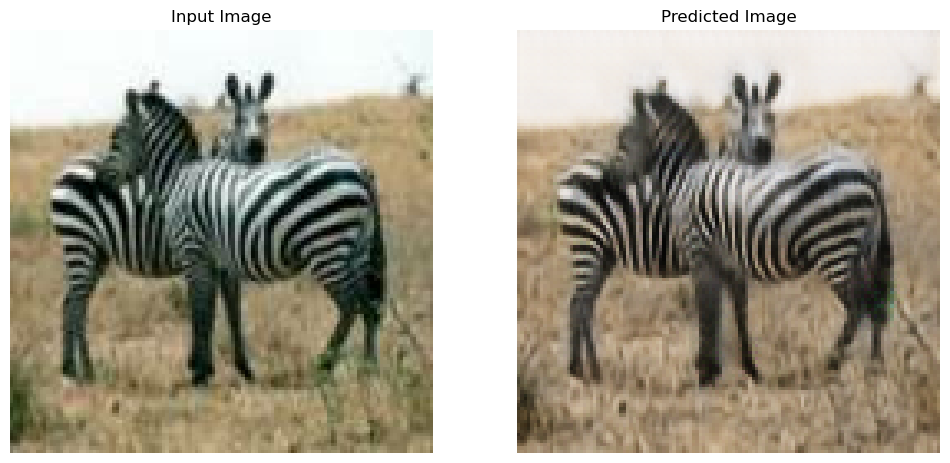

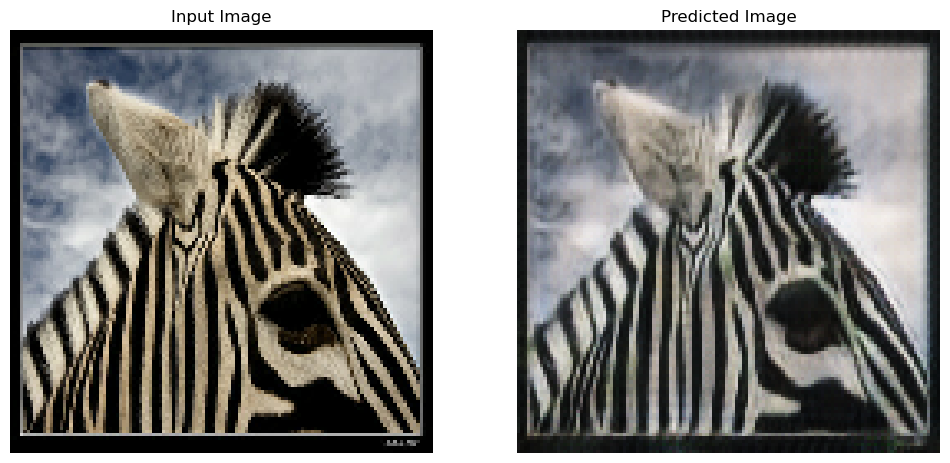

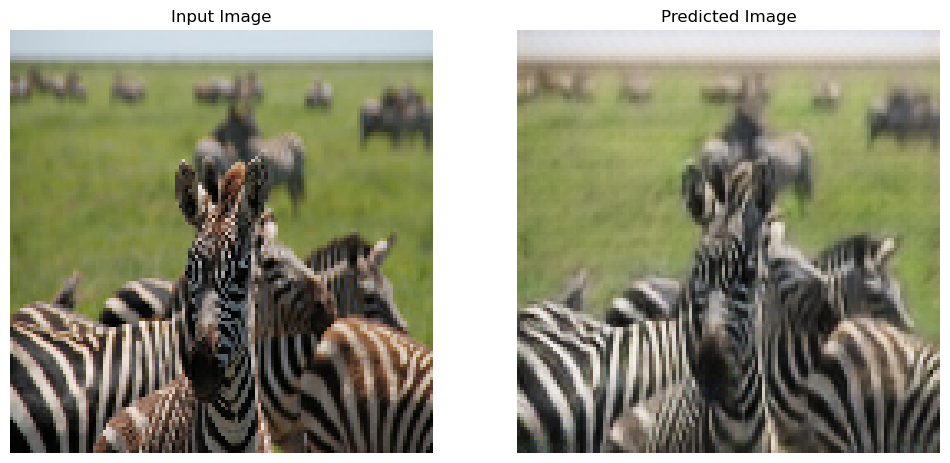

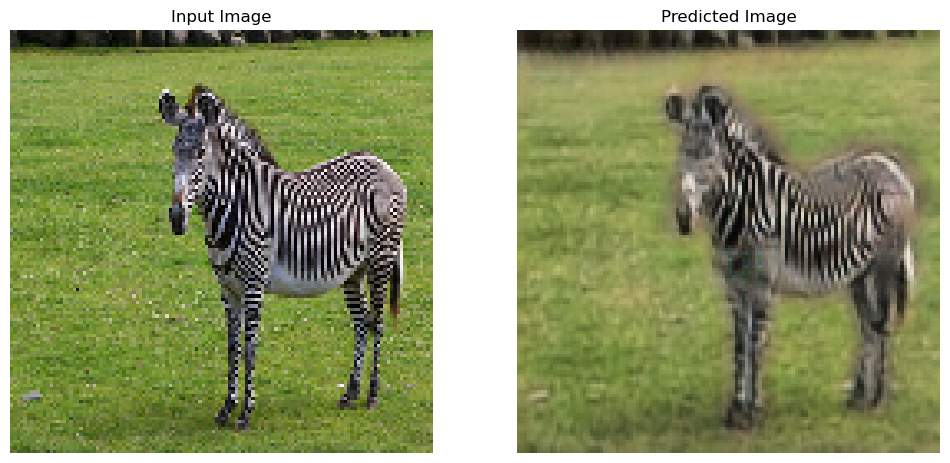

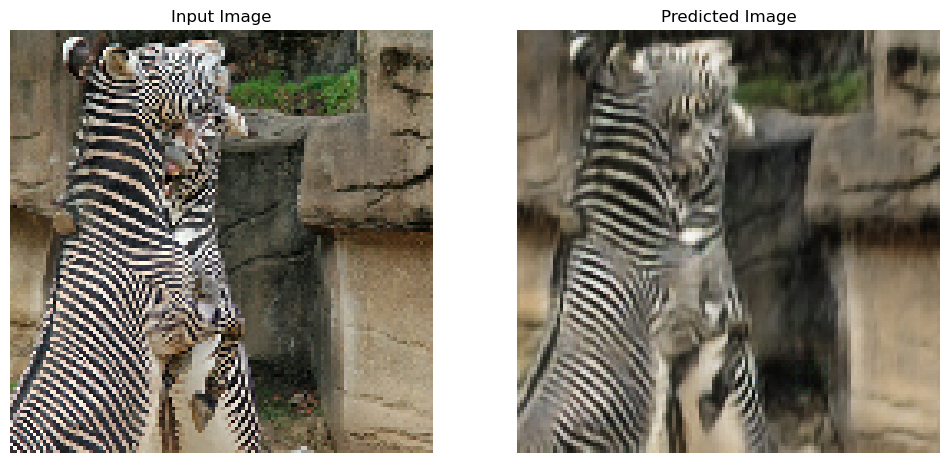

In [19]:
for img in test_zebras.take(5):
    generate_images(generator_g, img)